## Import data & libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import data_table
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Data/03 Feature Selected Data/final_df_next_day_20210919_10.csv').reset_index(drop=True)
final_df

,Date,sma90 avg_transaction_value,ema90 avg_transaction_value,dema7 opening_price,closing_price,wma30 avg_transaction_value,ema30 avg_transaction_value,tema90 avg_transaction_value,opening_price,tema7 closing_price,bband_upper30 closing_price,next_day_closing_price
0,2013-04-01,0.000000,0.000000,0.000377,0.000561,0.001013,0.000750,0.000000,0.000388,0.000590,0.000000,118.0
1,2013-04-02,0.000082,0.000124,0.000469,0.000781,0.001185,0.000925,0.000224,0.000561,0.000769,0.000101,135.0
2,2013-04-03,0.000169,0.000247,0.000621,0.001049,0.001354,0.001095,0.000444,0.000781,0.001014,0.000241,132.1
3,2013-04-04,0.000248,0.000360,0.000833,0.001004,0.001499,0.001237,0.000639,0.001049,0.001111,0.000354,142.3
4,2013-04-05,0.000328,0.000474,0.000944,0.001164,0.001643,0.001377,0.000831,0.001004,0.001242,0.000480,142.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3088,2021-09-14,0.962009,0.987119,0.713871,0.740622,1.000000,1.000000,1.000000,0.707069,0.719939,0.790106,48130.6
3089,2021-09-15,0.971827,0.991312,0.724588,0.757213,0.992880,0.987087,0.994430,0.740477,0.740076,0.790388,47748.0
3090,2021-09-16,0.982980,0.997794,0.739332,0.751185,0.989533,0.979753,0.993288,0.757200,0.748003,0.789290,47282.8
3091,2021-09-17,0.991883,0.998428,0.746433,0.743856,0.974805,0.961515,0.981553,0.751149,0.747889,0.787836,48306.7


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

## Train Test Split

In [ ]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|██████████| 26/26 [00:00<00:00, 10904.10it/s]


In [ ]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='next_day_closing_price',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

In [ ]:
for i in range(len(train_splits)):
    visualize_split(i)

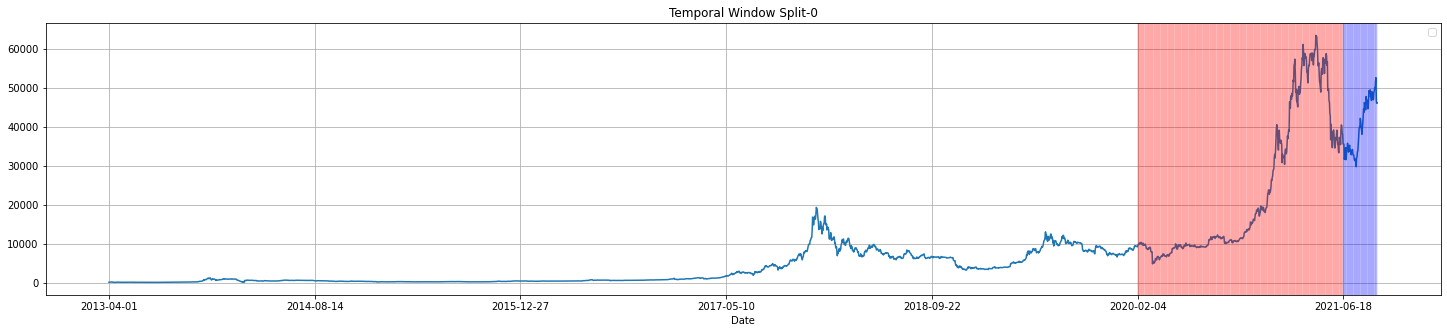

In [ ]:
visualize_split(-1)

In [ ]:
import shutil
shutil.make_archive('plot', 'zip', '/content/plot')

'/content/plot.zip'

In [ ]:
from kora.drive import upload_public
url = upload_public('/content/WhatsApp Video 2021-09-06 at 21.45.22.mp4')
# then display it
from IPython.display import HTML

In [ ]:
HTML(f"""<video src={url} width=500 controls/>""")

## Dummy Regressor

In [ ]:
dmy_date_array = []
dmy_y_test_array = []
dmy_y_test_pred_array = []
dmy_batch_id_array = []
dmy_batch_id_array_result = []
dmy_batch_mae_train_array = []
dmy_batch_rmse_train_array = []
dmy_batch_mae_test_array = []
dmy_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    dmy = DummyRegressor(strategy="quantile",quantile=0.9)
    dmy.fit(Xtrain_split, ytrain_split)

    ytrain_pred = dmy.predict(Xtrain_split)
    ytest_pred = dmy.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    dmy_date_array.extend(test_splits[i]['Date'])
    dmy_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    dmy_y_test_pred_array.extend((ytest_pred.flatten()))
    dmy_batch_id_array.extend([i]*len(test_splits[i]))

    dmy_batch_id_array_result.append(i)
    dmy_batch_mae_train_array.append(MAE_train)
    dmy_batch_rmse_train_array.append(RMSE_train)

    dmy_batch_mae_test_array.append(MAE_test)
    dmy_batch_rmse_test_array.append(RMSE_test)

dmy_result_test_df = pd.DataFrame()
dmy_result_test_df['batch_id'] = dmy_batch_id_array
dmy_result_test_df['Date'] = dmy_date_array
dmy_result_test_df['y_test'] = dmy_y_test_array
dmy_result_test_df['y_test_pred'] = dmy_y_test_pred_array
dmy_y_test_array = dmy_result_test_df['y_test']
dmy_y_test_pred_array = dmy_result_test_df['y_test_pred']
dmy_result_metrics_df = pd.DataFrame()
dmy_result_metrics_df['batch_id'] = dmy_batch_id_array_result
dmy_result_metrics_df['mae_train'] = dmy_batch_mae_train_array
dmy_result_metrics_df['rmse_train'] = dmy_batch_rmse_train_array
dmy_result_metrics_df['mae_test'] = dmy_batch_mae_test_array
dmy_result_metrics_df['rmse_test'] = dmy_batch_rmse_test_array

100%|██████████| 26/26 [00:00<00:00, 370.13it/s]


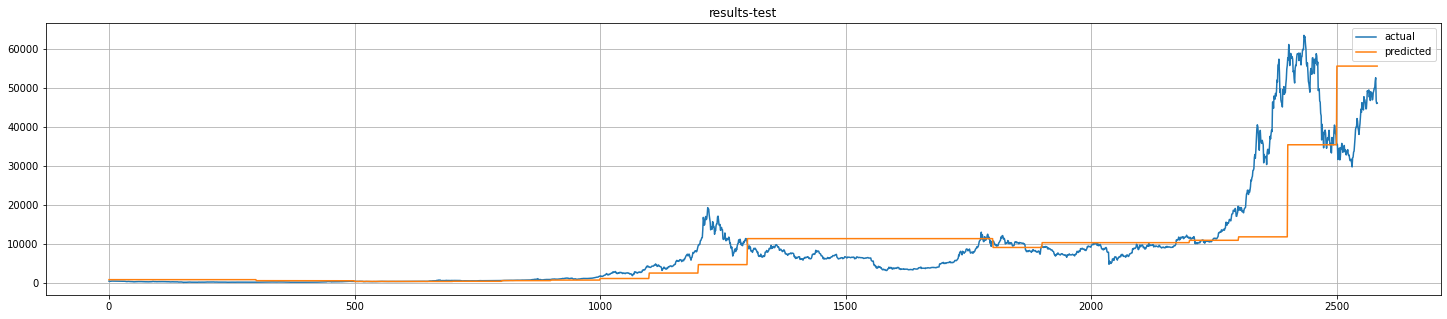

In [ ]:
plot_results(dmy_y_test_array,dmy_y_test_pred_array,'results-test')

In [ ]:
dmy_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/dmy_result_test_20210920.csv')

In [ ]:
pd.DataFrame(dmy_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,4200.110862
rmse_train,4680.817501
mae_test,3934.774491
rmse_test,4344.374628


## SVR

In [ ]:
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []
svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)

    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 26/26 [00:00<00:00, 27.31it/s]


In [ ]:
svr_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/svr_result_test_20210920.csv')

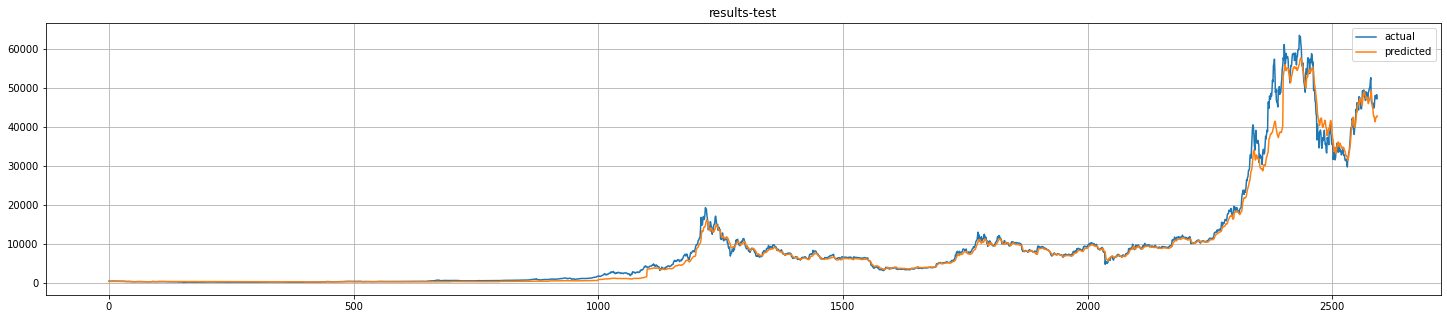

In [ ]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

## XGBoost

In [ ]:
xgb_date_array = []
xgb_y_test_array = []
xgb_y_test_pred_array = []
xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_mae_train_array = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_mae_test_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []
for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    xgbm_reg.fit(Xtrain_split, ytrain_split)

    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_mae_train_array.append(MAE_train)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_mae_test_array.append(MAE_test)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array
xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']
xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['mae_train'] = xgb_batch_mae_train_array
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['mae_test'] = xgb_batch_mae_test_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████| 26/26 [00:06<00:00,  4.27it/s]


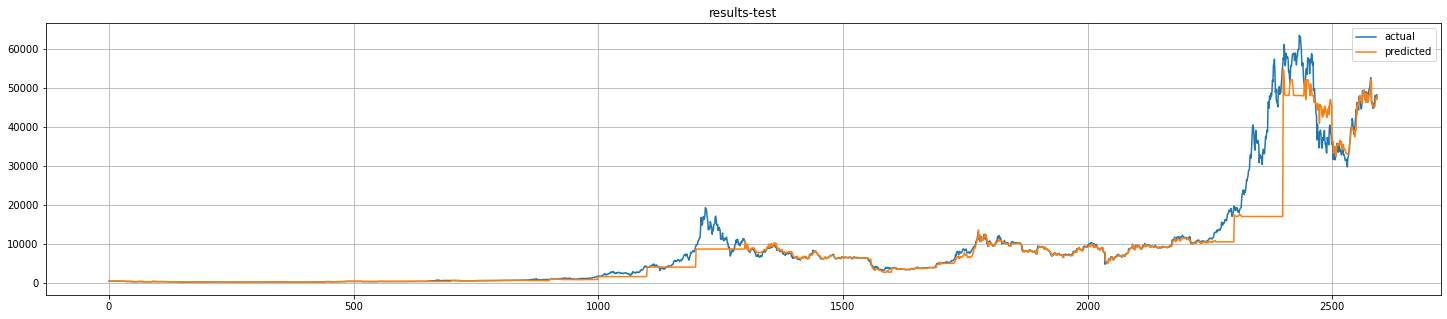

In [ ]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [ ]:
xgb_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/xgb_result_test_20210920.csv')

In [ ]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,107.050812
rmse_train,170.587782
mae_test,1509.839623
rmse_test,1834.349936


## Linear Regression

In [ ]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)

    pickle.dump(sgd_reg, open(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Linear Regression Model/linear_reg_10_{i}.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|██████████| 26/26 [00:01<00:00, 18.24it/s]


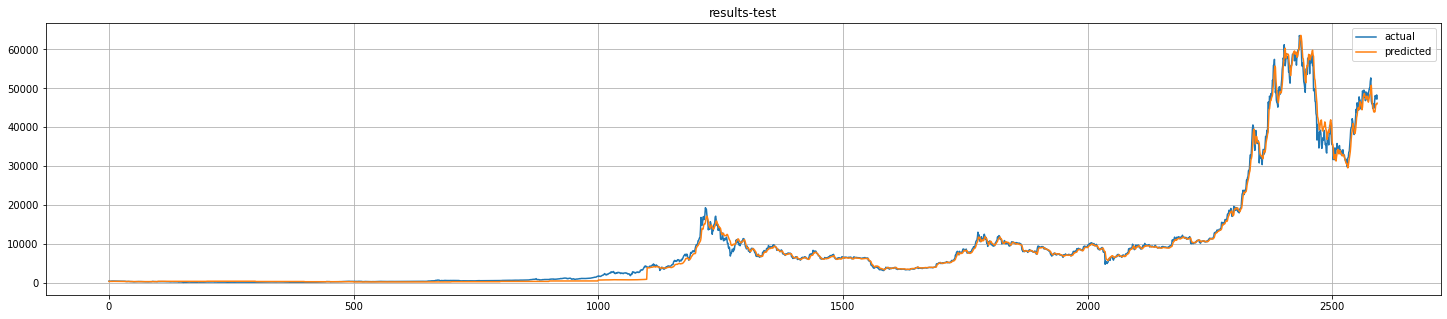

In [ ]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [ ]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,240.991809
rmse_train,371.840538
mae_test,559.397944
rmse_test,684.216603


In [ ]:
lr_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_test_20210920.csv')

## LSTM

### Callbacks

#### EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

####  Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [ ]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [ ]:
callback_list=[reduce_lr,lrschedule,earlystop]

### Build Model

In [ ]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = Bidirectional(LSTM(400, return_sequences=True,activation='relu'),name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = Bidirectional(LSTM(500, return_sequences=True,activation='relu'),name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 10)]           0         
_________________________________________________________________
lstm_1 (Bidirectional)       (None, 1, 800)            1315200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 800)            0         
_________________________________________________________________
lstm_2 (Bidirectional)       (None, 1, 1000)           5204000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1000)           0         
_________________________________________________________________
output_layer (Dense)         (None, 1, 1)              1001      
Total params: 6,520,201
Trainable params: 6,520,201
Non-trainable params: 0
___________________________________________________

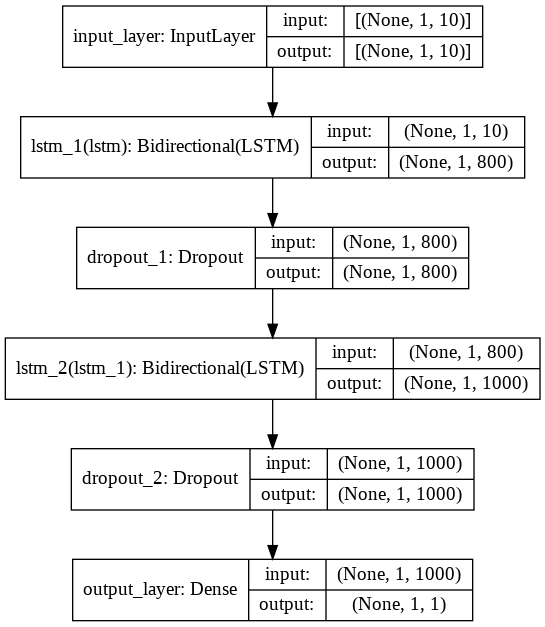

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
# path = '/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/Model Train10'
# if not os.path.exists(path):
#     os.makedirs(path)
# if not os.path.exists(f'{path}/pickled_arrays'):
#     os.makedirs(f'{path}/pickled_arrays')

In [ ]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_mae_train_array = []
lstm_batch_rmse_train_array = []
lstm_batch_mae_test_array = []
lstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    print(f'Batch No. {i+1} of {len(train_splits)}')
    print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
          'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
          'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/LSTM/lstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lstm_date_array.extend(test_splits[i]['Date'])
    lstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(test_splits[i]))

    lstm_batch_id_array_result.append(i)
    lstm_batch_mae_train_array.append(MAE_train)
    lstm_batch_rmse_train_array.append(RMSE_train)
    lstm_batch_mae_test_array.append(MAE_test)
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
# result_df.to_csv(f'{path}/result.csv')
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']
lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['mae_train'] = lstm_batch_mae_train_array
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['mae_test'] = lstm_batch_mae_test_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array

Streaming output truncated to the last 5000 lines.
16/16 - 1s - loss: 273.3387 - root_mean_squared_error: 541.2244 - mae: 273.8361
Epoch 00087: early stopping
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/LSTM/lstm_14/assets
****************************************************************************************************
Batch No. 15 of 26
Train Data From 2017-01-30 - 939.7 to 2018-06-13 - 19345.5
Test Data From 2018-06-14 - 5883.5 to 2018-09-21 - 8407.0
Epoch 1/500

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
16/16 - 6s - loss: 356.8909 - root_mean_squared_error: 604.1568 - mae: 357.3908
Epoch 2/500

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 - 1s - loss: 380.3722 - root_mean_squared_error: 627.2210 - mae: 380.8715
Epoch 3/500

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
16/16 - 1s - loss: 354.4379 - root_mean_squar

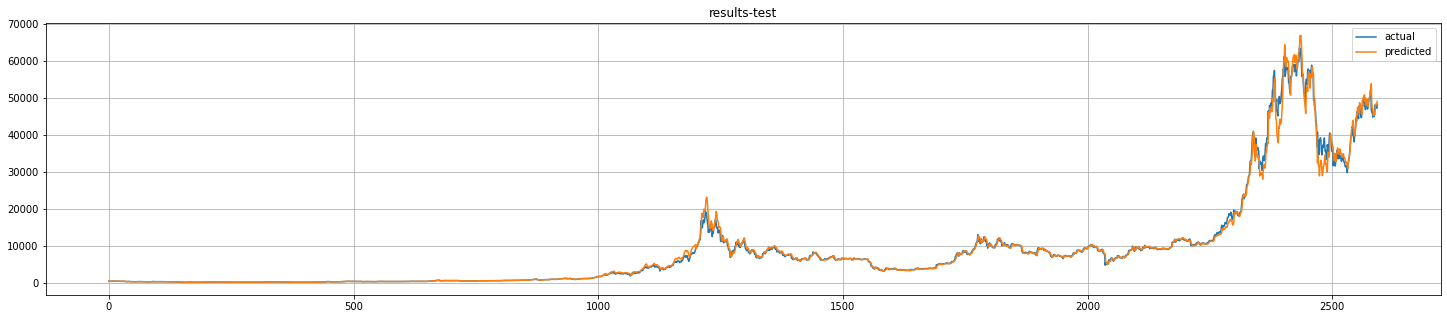

In [ ]:
plot_results(lstm_y_test_array,lstm_y_test_pred_array,'results-test')

In [ ]:
lstm_result_metrics_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lr_result_metrics_20210920.csv')
lstm_result_test_df.to_csv('/content/drive/MyDrive/Self Case studies/CS01 Bitcoin Price Forecasting/lstm_result_test_20210920.csv')

In [ ]:
lstm_result_metrics_df.mean()

batch_id       12.500000
mae_train     163.168198
rmse_train    284.222848
mae_test      452.906086
rmse_test     607.672991
dtype: float64